In [1]:
import warnings

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from scipy import stats

In [2]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Gaukhar-ai/for_my_Thinkful_work/master/capstone/NY_real_estate/nyc-rolling-sales.csv')
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [12]:
df.shape

(84548, 10)

In [4]:
#dropping highly correlated and unnecessary columns:

drop_cols = ['TAX CLASS AT PRESENT', 'Unnamed: 0', 'NEIGHBORHOOD', 'BOROUGH', 'BLOCK', 'BUILDING CLASS AT PRESENT', 'LOT', 'EASE-MENT', 
            'APARTMENT NUMBER', 'BUILDING CLASS AT TIME OF SALE', 'TOTAL UNITS', 'ADDRESS']
df.drop(columns = drop_cols, inplace=True) 

In [5]:
df.head()

,BUILDING CLASS CATEGORY,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,07 RENTALS - WALKUP APARTMENTS,10009,5,0,1633,6440,1900,2,6625000,2017-07-19 00:00:00
1,07 RENTALS - WALKUP APARTMENTS,10009,28,3,4616,18690,1900,2,-,2016-12-14 00:00:00
2,07 RENTALS - WALKUP APARTMENTS,10009,16,1,2212,7803,1900,2,-,2016-12-09 00:00:00
3,07 RENTALS - WALKUP APARTMENTS,10009,10,0,2272,6794,1913,2,3936272,2016-09-23 00:00:00
4,07 RENTALS - WALKUP APARTMENTS,10009,6,0,2369,4615,1900,2,8000000,2016-11-17 00:00:00


In [6]:
#let's see how many rows have null values:

df.isnull().sum()

BUILDING CLASS CATEGORY      0
ZIP CODE                     0
RESIDENTIAL UNITS            0
COMMERCIAL UNITS             0
LAND SQUARE FEET             0
GROSS SQUARE FEET            0
YEAR BUILT                   0
TAX CLASS AT TIME OF SALE    0
SALE PRICE                   0
SALE DATE                    0
dtype: int64

In [7]:
df.dtypes

BUILDING CLASS CATEGORY      object
ZIP CODE                      int64
RESIDENTIAL UNITS             int64
COMMERCIAL UNITS              int64
LAND SQUARE FEET             object
GROSS SQUARE FEET            object
YEAR BUILT                    int64
TAX CLASS AT TIME OF SALE     int64
SALE PRICE                   object
SALE DATE                    object
dtype: object

In [8]:
col = df[0:]
for c in col:
    print("Value counts for " + c)
    print(df[c].value_counts())

Value counts for BUILDING CLASS CATEGORY
01 ONE FAMILY DWELLINGS                         18235
02 TWO FAMILY DWELLINGS                         15828
13 CONDOS - ELEVATOR APARTMENTS                 12989
10 COOPS - ELEVATOR APARTMENTS                  12902
03 THREE FAMILY DWELLINGS                        4384
07 RENTALS - WALKUP APARTMENTS                   3466
09 COOPS - WALKUP APARTMENTS                     2767
04 TAX CLASS 1 CONDOS                            1656
44 CONDO PARKING                                 1441
15 CONDOS - 2-10 UNIT RESIDENTIAL                1281
05 TAX CLASS 1 VACANT LAND                       1248
17 CONDO COOPS                                   1201
22 STORE BUILDINGS                                935
12 CONDOS - WALKUP APARTMENTS                     926
14 RENTALS - 4-10 UNIT                            671
29 COMMERCIAL GARAGES                             587
43 CONDO OFFICE BUILDINGS                         475
31 COMMERCIAL VACANT LAND                

In [9]:
df.describe()

,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE
count,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000
mean,10731.991614,2.025264,0.193559,1789.322976,1.657485
std,1290.879147,16.721037,8.713183,537.344993,0.819341
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,10305.000000,0.000000,0.000000,1920.000000,1.000000
50%,11209.000000,1.000000,0.000000,1940.000000,2.000000
75%,11357.000000,2.000000,0.000000,1965.000000,2.000000
max,11694.000000,1844.000000,2261.000000,2017.000000,4.000000


In [10]:
df['SALE PRICE'].describe()

count     84548
unique    10008
top         -  
freq      14561
Name: SALE PRICE, dtype: object

In [16]:
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')


In [18]:
df['SALE PRICE'].describe()

count    6.998700e+04
mean     1.276456e+06
std      1.140526e+07
min      0.000000e+00
25%      2.250000e+05
50%      5.300000e+05
75%      9.500000e+05
max      2.210000e+09
Name: SALE PRICE, dtype: float64

In [24]:
num_cols = ['SALE PRICE', 'GROSS SQUARE FEET', 'LAND SQUARE FEET' ]

bin_cols = []

cat_cols =  ['BUILDING CLASS CATEGORY', 'ZIP CODE', 'SALE DATE', 'TAX CLASS AT TIME OF SALE', 'YEAR BUILT',  ]
drop_cats = []


In [21]:
#let's see how many nulls in sale price

df['SALE PRICE'].isnull().sum()

14561

In [25]:
df['GROSS SQUARE FEET'].isnull().sum()


26252

In [26]:
df['LAND SQUARE FEET'].isnull().sum()

26252

I see lots of NaS in these three above categories. so I'm going to fill them up with the mean

In [28]:
df['LAND SQUARE FEET']=df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET']=df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())

In [31]:
# Splitting the data

test=df[df['SALE PRICE'].isna()]
data=df[~df['SALE PRICE'].isna()]

In [32]:
print(test.shape)
test.head()

(14561, 10)


,BUILDING CLASS CATEGORY,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
1,07 RENTALS - WALKUP APARTMENTS,10009,28,3,4616.0,18690.0,1900,2,NaN,2016-12-14 00:00:00
2,07 RENTALS - WALKUP APARTMENTS,10009,16,1,2212.0,7803.0,1900,2,NaN,2016-12-09 00:00:00
5,07 RENTALS - WALKUP APARTMENTS,10009,20,0,2581.0,9730.0,1900,2,NaN,2017-07-20 00:00:00
7,07 RENTALS - WALKUP APARTMENTS,10009,44,2,5163.0,21007.0,1900,2,NaN,2017-07-20 00:00:00
8,08 RENTALS - ELEVATOR APARTMENTS,10009,15,0,1534.0,9198.0,1920,2,NaN,2017-06-20 00:00:00


<AxesSubplot:>

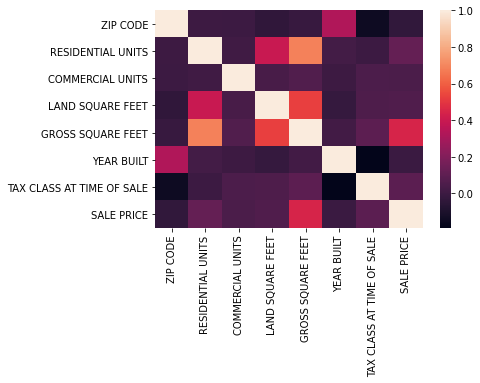

In [33]:
corr = df.corr()
sns.heatmap(corr)

In [34]:
corr['SALE PRICE'].sort_values(ascending=False)

#looking at the price and its correlation to other numeric data

SALE PRICE                   1.000000
GROSS SQUARE FEET            0.444508
RESIDENTIAL UNITS            0.119698
TAX CLASS AT TIME OF SALE    0.091352
LAND SQUARE FEET             0.059079
COMMERCIAL UNITS             0.046006
YEAR BUILT                  -0.003539
ZIP CODE                    -0.034170
Name: SALE PRICE, dtype: float64

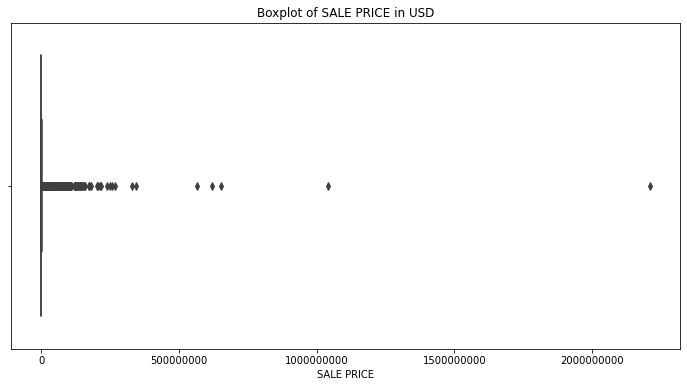

In [38]:
plt.figure(figsize=(12,6))

sns.boxplot(x='SALE PRICE', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

wow, I see some very far outliers, which might be pattern brakers. Let's get rid of them for now, then I can investigate them futhermore. 

In [45]:
data = data[(data['SALE PRICE'] > 100000) & (data['SALE PRICE'] < 5000000)]

<AxesSubplot:xlabel='SALE PRICE'>

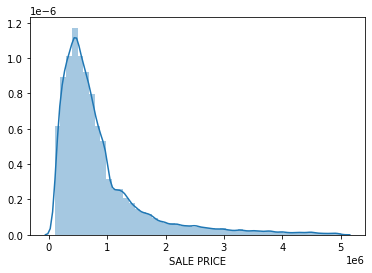

In [46]:
sns.distplot(data['SALE PRICE'])
#right skewed

0.1989281802313763


<AxesSubplot:xlabel='SALE PRICE'>

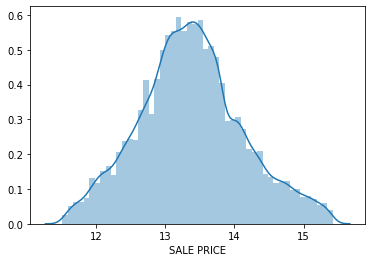

In [48]:
sale_price=np.log(data['SALE PRICE'])
print(sale_price.skew())
sns.distplot(sales)

In [ ]:
#by using the log, the data is now normailized. 